# 0. Intro

### Dataset

Project Sentiment Analysis bertujuan untuk mengembangkan sistem cerdas berbasis teknologi AI untuk mengklasifikasi sentiment pada twitter dengan metode text analysis. Sistem ini akan membantu memperoleh **kecenderungan sentimen opini positif, negatif atau netral** dari pengguna di platform tersebut.

Dataset yang digunakan adalah kumpulan tweet dari pengguna twitter saat pelaksanaan **Pilpres 2019**. Dataset tersebut  didapat melalui proses web scraping. Data terdiri dari 1815 tweet yanng memuat tiga kategori sentimen: positif, netral, dan negatif.

### Alur Pelaksanaan

Eksperimen dilakukan dengan menggunakan berbagai ragam teknik preprocessing dan vectorization. Selain itu juga menggunakan **menguji algoritma Random Forest dan LSTM (ditambah hyperparameter tuning untuk model optimization)**.

Setelah itu dilakukan model evaluation dan penarikan kesimpulan untuk memilih algoritma terbaik.

# 1. Data Loading

In [1]:
import pandas as pd
import nltk
pd.set_option('display.max_colwidth',None)

In [2]:
tweets = pd.read_csv('./dataset/tweet.csv', index_col=0)

# 2. EDA (before text cleaning)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 42.5+ KB


In [5]:
tweets.shape

(1815, 2)

In [6]:
tweets.isnull().sum()

sentimen    0
tweet       0
dtype: int64

In [7]:
tweets.head()

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


## 2.1. Distribution of Sentiment

In [8]:
tweets.sentimen.value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

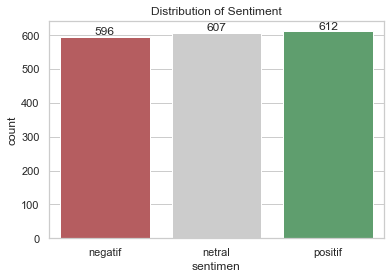

In [9]:
color_palette = {'negatif': 'r', 'netral': '#CCCCCC', 'positif': 'g'}

ax = sns.countplot(data=tweets, x='sentimen', palette=color_palette)
for p in ax.patches:
    ax.annotate(format(p.get_height(),'.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Sentiment')
plt.show()

## 2.2. Number word string

In [10]:
tweets['num_words'] = tweets['tweet'].apply(lambda x:len(str(x).split())) 

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

### 2.2.1. All Sentiment

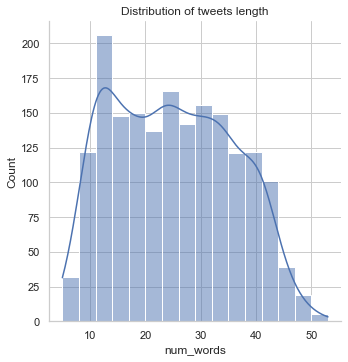

In [11]:
sns.displot(tweets['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.2. negatif sentiment

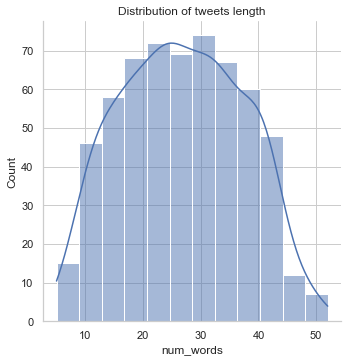

In [12]:
sns.displot(tweets_negatif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.3. netral sentiment

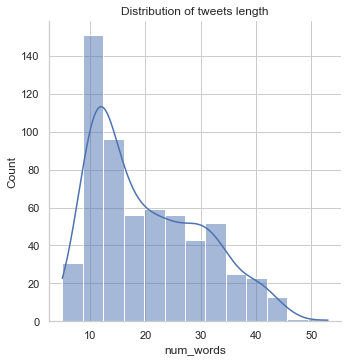

In [13]:
sns.displot(tweets_netral['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.4. positif sentiment

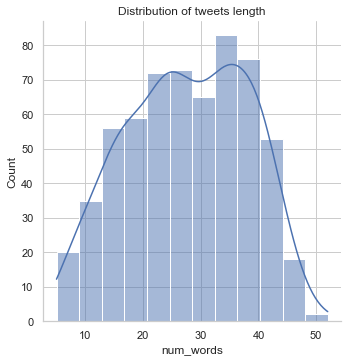

In [14]:
sns.displot(tweets_positif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

# 3. Text Preprocessing

0. Remove url and punctuation
1. Slang words to standard words conversion
2. Tokenization
3. Stemming & Lemmatization
4. Stop words removal
5. Word embedding

In [15]:
import re
import string

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### create list stopword

perlu tambahkan beberapa stopword

ga, gak, yg, pak, akan, utk, di, untuk, itu

wowo --> prabowo

In [16]:
class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
    def get_stop_words(self):
        
        add_sw = ['ga', 'gak', 'yg', 'pak','bapak','ibu','bu','akan', 'utk', 'di', 'untuk', 'itu','selain itu'
                 ,"ud","udah","sdh","sudah","kalau","klo","sy","aing","saia","gue","awak","aq","gua","gw","ak","aku","saya","banget","blibli","tokopedia","shopee","bukalapak","lazada","jdid","zalora","elevenia","sudah","bhinneka","gk","yg","ga","gak","nggak","saja","aja","aj","ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai"
                ,"berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui"
            ,"diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah"
            ,"jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui"
            ,"melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang","anjing","anjiang","anjir","anjay","anying","asu","asoe","babi","bajingan","banci","bangsat","bego","bengak","berak","bokong","bodoh","bongak","edan","fak","fuck","fakboi","bitch","fap","gigolo","goblok","gila","gilo","jablay","jalang","jancuk","jancok","kampret","kafir","kontol","kentot","dancok","kunyuk","kufar","kimak","homo","maho","memek","monyet","ngentot","pantat","pantak","pantek","pecun","pelakor","ngehe","pelacur","perek","peler","pepek","pukimak","setan","syaithon","saiton","sial","sialan","sinting","sintiang","silit","sontoloyo","tai","telek","tolol","lonte","entut","gimana","widihh","nya","gabisa","nambah","kontoll","ih","sih","selesai","banget","si","knapa","bngt","kamu","an","tanggal","dizalora","in","an","ini","emang","sngt","many","to","thank","you","ko","tumben","lho","segitu","kalau","doang","ayo","doank","rbuan","woi","parahhhh","trus","woy","emg","gausah","udh","gadak","huhh","akh","nanti","belum","cuiiihhh","bangt","selamat","begitu","bhineka","situ","loh","deh","mah","yaa","tapi","the","karena","padabal","ttep","sopi","ealah","mas","kampreeeeet","busetttt","tahi","ah","sich","tokped","lzd","gada","gatau","udh","ttep","ehhh","bosss","wkekwk","bajing","laknat","asuuu","ku","woiii","gueeee","njerr","waduhhhh","ma","dunk","dunk","untuk","dll","brupa","sangatx","niih","bos","eh","smua","gni","bye","ajah","gilee","luu","ndro","dg","kga","min","sm","haisshhh","piye","iki","skali","hehehe","ms","juga","fff","mamam","inibsangat","andri","yopiyanto","broo","donk","tes","si","ter","dech","wow","oh","toped","dahhhh","grab","ijo","oren","ovo","gopay","kredivo","sok","david","gaes","dr","ovonya","bbrp","gmna","bbrpa","and","uah","uhahhhhhh","topeeed","ngak","kamu","anj","nge","lah","linkaja","gosend","sicepat","jne","yah","goto","gofood","goride","prakerja","haduhhhh","pediya","kakak","hhe","bro","bismillah","fuulll","goof","assalamualaikum","atsu","pea","you","agan","semenjak","gojek","lagiii","lagi","bts","kkzara","cog","aaaaa","sich","cih","ciyy","padahal","ad","adlh","ahaha","aj","ak","akika","akkoh","akuwh","alow","anjrit","ap2","apasih","aps","aq","aqueh","q","asem","ato","awak","bakalan","bangedh","bcanda","beud","bg","bgmn","bgt","bkl","bknnya","blum","boljug","boyeh","bs","bt","btw","bwt","byk","can","thanks","d","dah","dapet","de","dek","deyh","dgn","disono","dkk","dlu","dngn","dongs","dpt","dri","drmn","drtd","dst","duh","egp","eke","ane","ente","elu","emangnya","emng","endak","enggak","gaada","gag","gaje","gpp","gan","gbs","geje","ghiy","gimana","githu","gj","gn","gt","gpny","gr","gtau","guoblok","ha","haha","hallow","hehe","helo","he","halo","hey","hai","hny","hrus","imho","iye","ja","jadiin","jdi","jga","jir","k","kagak","kalo","kamuwh","karna","katrok","kayanya","kdu","kepengen","kepingin","kl","klianz","klw","km","knp","kpn","kt","kyk","leh","lgi","lgsg","liat","low","lum","maneh","mao","mw","n","napa","nda","ne","ngapah","ngga","ngmng","nie","nih","niyh","np","ogah","pd","pi","pisan","qmu","ruz","saia","samsek","siech","sj","spt","sgt","shg","scr","sbh","sbnrny","sdgkn","td","thankz","tks","ttg","tuch","tuh","u","urang","yawdah","yasudah","adlah","ajj","akko","akyu","ama","aqu","atuh","ayok","bet","beut","bgd","brur","bapak","ibu","bokap","nyokap","cama","ceu","teh","coz","cpa","guys","kaka","kamuh","kamyu","kau","khan","kk","klian","koq","ky","krn","kykny","lu","lw","maaciw","makasih","mba","mas","nyok","qmo","qt","spy","sy","thanks","thx","tp","tq","trims","mz","alfamart","cm","buruk","lambat","jelek","bagus","ok","oke","kecewa","mantap","manfaat","gblk","ni","keren","bagus","ajg","iya","tidak","muas","puas","goblog","tdk","dancuk","huff","lumayan","mayan","y","eek","belum","blm","nyesel","bahagia","senang","seneng","mantul","good","top","suka","not","bad","kak","okey","gitu","coba","sip","nice","job","thanks","terima kasih","moga","lasada","jd","id","parah","for","sumpah","best","bli","payah","blibi","blipay","gg","love","amazing","mantab","terimakasih","cakep","very","bgs","jos","is","euy","gandos","of","waw","biar","buka","lapak","terima","kasih","alhamdulillah","pokok","shoope","shoppe","shope","san"
                 ]
        
        with open('stopwords/20190327_stopword_id.txt') as sw:  # use the stopword list
            new_sw = sw.readlines()
            new_sw = [value.replace('\n', '').strip() for value in new_sw]
            
            new_sw = new_sw + add_sw              # add the additional stopwords
            
        new_sw.extend(super().get_stop_words())   # combine stopword from Sastrawi and custom stopwords
        return list(set(new_sw))                  # using set() to remove duplication values

In [17]:
# create sastrawi stopwords object
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

### text cleaning and normalization

In [18]:
# text cleaning

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text, sw_remover):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()                                               # case folding
    text = re.sub('\[.*?\]', '', text)                                     # remove punctuation
    text = re.sub('<.*?>+', '', text)                                      # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)        # remove punctuation
    text = re.sub('https?://\S+|www\.\S+', '', text)                       # remove all url starts with http or https
    text = re.sub('\n', '', text)                                          # remove newline character 
    text = re.sub('\w*\d\w*', '', text)                                    # remove any word with number character in the middle
    text = re.sub('[^0-9a-zA-Z ]*', '', text)                              # remove all non-alphanumerical characters
    
    # Define the words to be replaced in a dictionary
    words_to_replace = {
        "yg": "",
        "yang": "",
        "di": "",
        "jadi": "",
        "itu": "",
        "ini": ""
    }
    
    for word, replacement in words_to_replace.items():
        text = text.replace(word, replacement)
    
    
    text = re.sub('#\w+', '', text)                                        # remove all hashtags
    text = re.sub(r'\s\s+', ' ', text)                                     # remove all consecutive whitespaces into only single whitespace 
    text = stemmer.stem(text)                                              # convert words into the stem form
    text = sw_remover.remove(text)                                         # remove stopwords
    return text

In [19]:
# text cleaning
tweets['cleaned_tweet'] = tweets['tweet'].apply(lambda x: clean_text(x, sw_remover))

In [20]:
# get hashtags
tweets['hashtags'] = tweets['tweet'].apply(lambda x: re.findall(r'#\w+', x.lower())) # Find all hashtags in the tweet

# 4. EDA (after text cleaning)

In [21]:
tweets['clean_num_words'] = tweets['cleaned_tweet'].apply(lambda x:len(str(x).split())) 

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

In [22]:
tweets.head()

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20


In [23]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentimen         1815 non-null   object
 1   tweet            1815 non-null   object
 2   num_words        1815 non-null   int64 
 3   cleaned_tweet    1815 non-null   object
 4   hashtags         1815 non-null   object
 5   clean_num_words  1815 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 99.3+ KB


## 4.1. Distribution of tweets length
### 4.1.1. All Sentiment

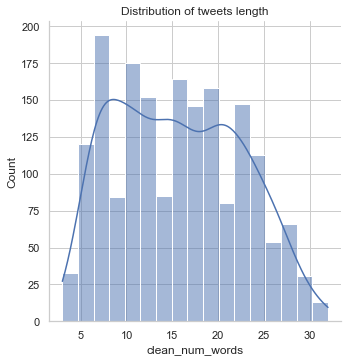

In [24]:
sns.displot(tweets['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.2. Negatif Data

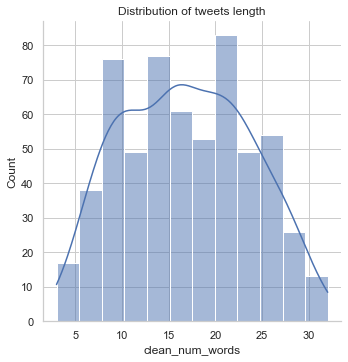

In [25]:
sns.displot(tweets_negatif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.3. Netral Data

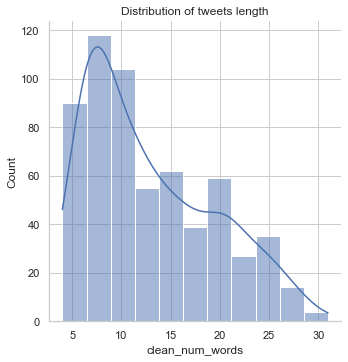

In [26]:
sns.displot(tweets_netral['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.4. Positif Data

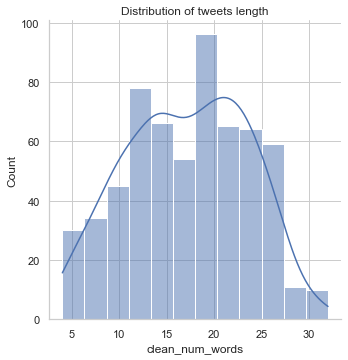

In [27]:
sns.displot(tweets_positif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

## 4.2. Text Tokenization

In [28]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
def tokenization_word(text):
    # do word tokenization
    tokens = word_tokenize(text)
    return tokens

In [30]:
tokenized_words = []

for idx in range(len(tweets['cleaned_tweet'])):
    cleaned = tokenization_word(tweets['cleaned_tweet'][idx])
    tokenized_words.append(cleaned)
    
# Top N words
def count_top_n_words(tokenized_words, n):
    word_counts = Counter(tokenized_words)
    top_n_words = word_counts.most_common(n)
    return top_n_words

tokenizer = RegexpTokenizer(r'\w+')

In [31]:
# Stick the new column to the DataFrame
tweets['tokenized tweet'] = tokenized_words

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

# Print the updated DataFrame
tweets.head()

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words,tokenized tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10,"[prabowo, indonesia, harga, bangsa, asing, berita, hoax, kuasa, kan, rockerung]"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9,"[batu, langka, tasbih, jokowi, haah, habib, luthfi, harga, mercy]"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7,"[era, jokowi, ekonomi, indonesia, baik, jokowilagi, jokowimenangtotaldebat]"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14,"[sumatera, selatan, asi, games, dampak, ekonomi, langsung, preksi, capai, triliun, indonesia, maju, jokowi, hebat]"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20,"[negara, ngutang, bngun, infrastruktur, pake, masyarakat, masyarakat, ngeluh, negara, ngutang, negara, ngutang, utang, bayar, negara, hasil, hasil, negara, dari, pajak]"


### 4.2.1. All  Sentiment

In [32]:
import itertools
from collections import Counter, OrderedDict

text_tweet = tweets['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

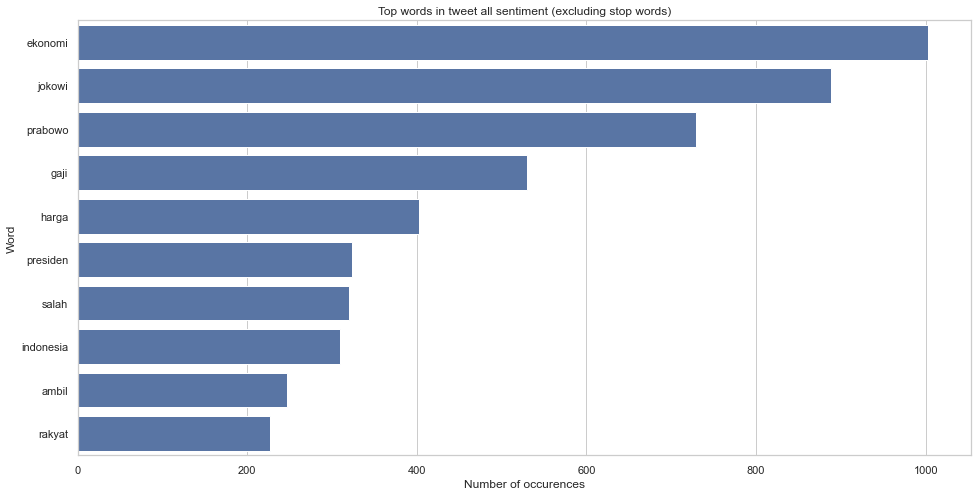

In [33]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top words in tweet all sentiment (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.2. Negatif Sentimen

In [34]:
text_tweet = tweets_negatif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet_negative = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

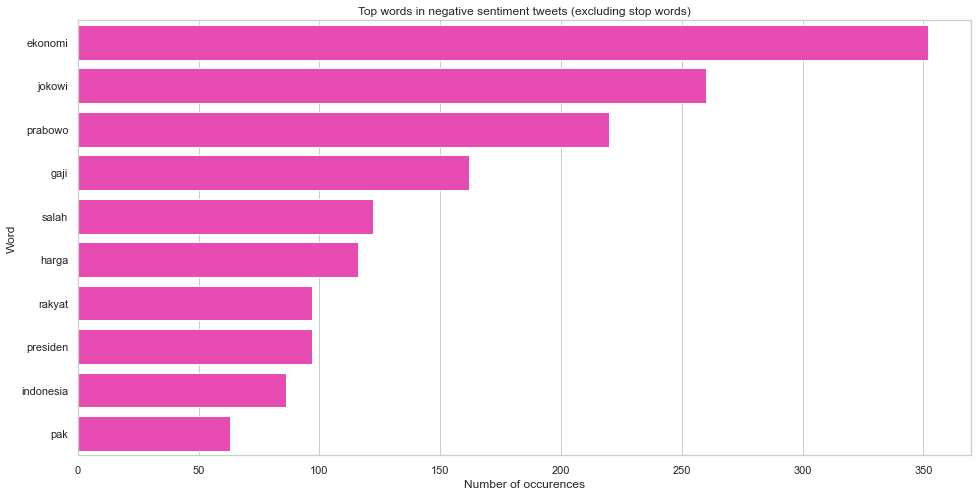

In [35]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet_negative, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top words in negative sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.3. Netral Sentimen

In [36]:
text_tweet = tweets_netral['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet_neutral = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

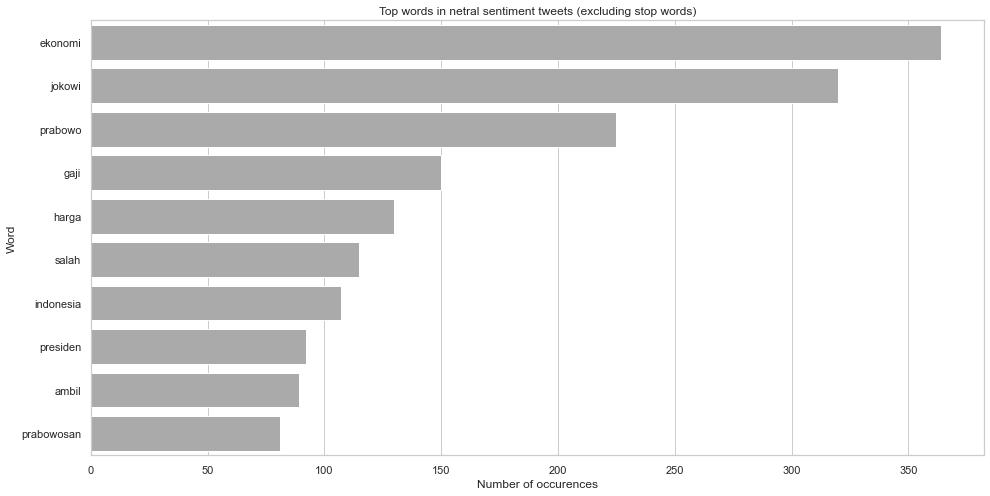

In [37]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet_neutral, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top words in netral sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.4. Positif Sentimen

In [38]:
text_tweet = tweets_positif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet_positive = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

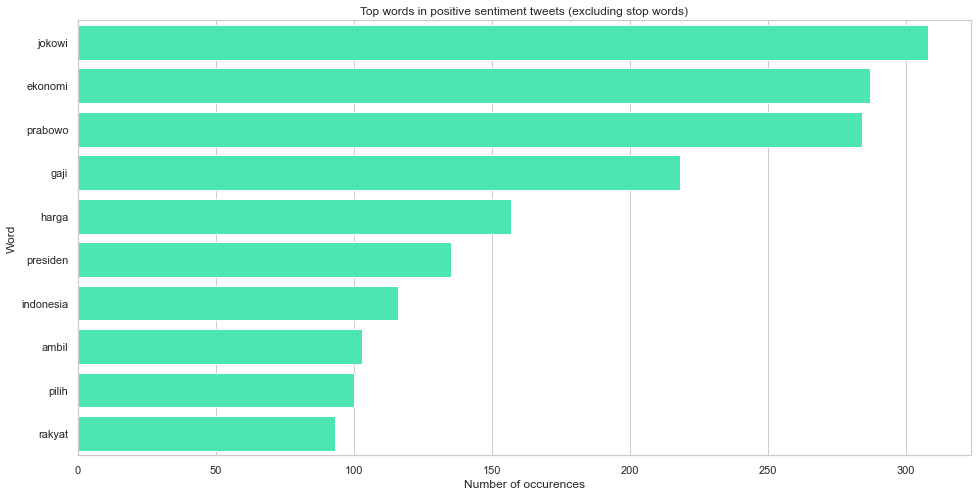

In [39]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet_positive, 10)  # get top 0 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top words in positive sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

## 4.3. Hashtag

### 4.3.1. All  Sentiment

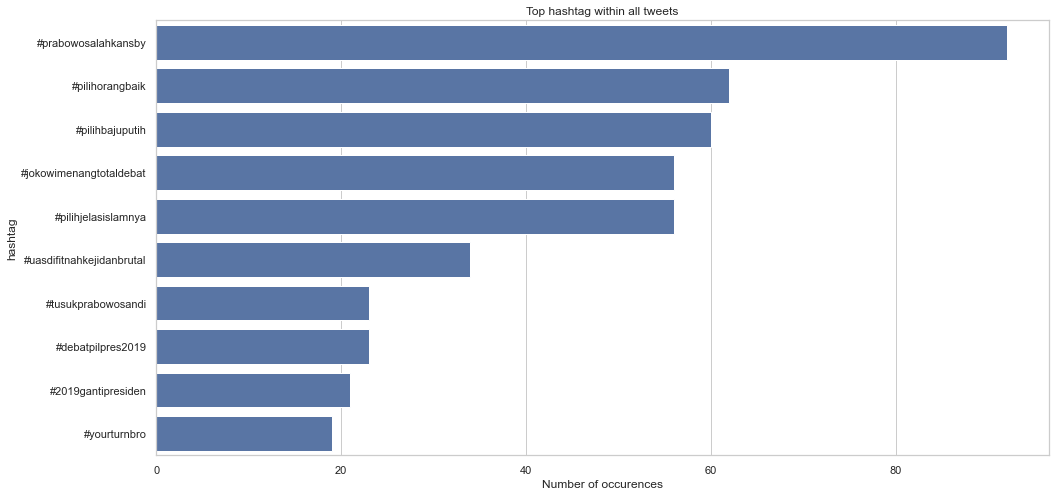

In [40]:
all_hashtags = []
_ = tweets['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top hashtag within all tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.2. Negative  Sentiment

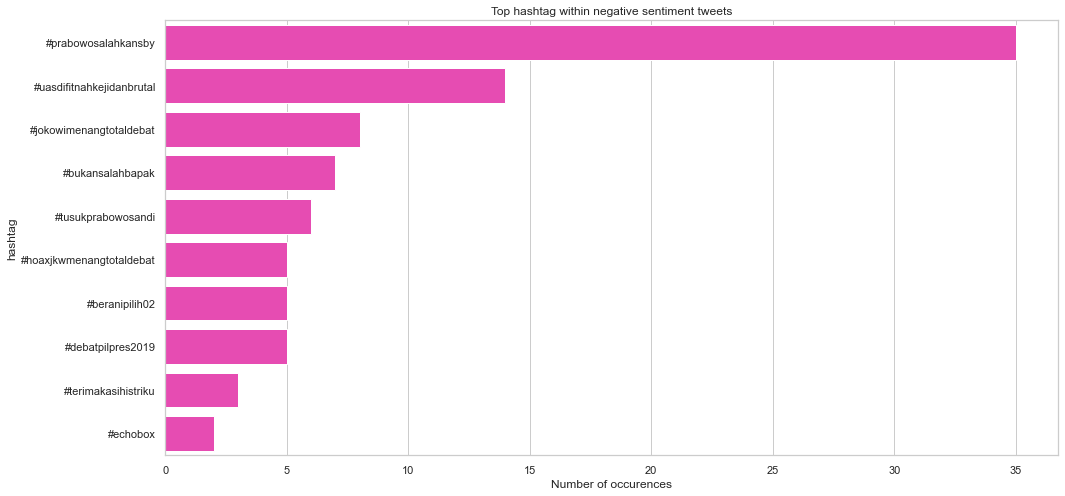

In [41]:
all_hashtags = []
_ = tweets_negatif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top hashtag within negative sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.3. Netral  Sentiment

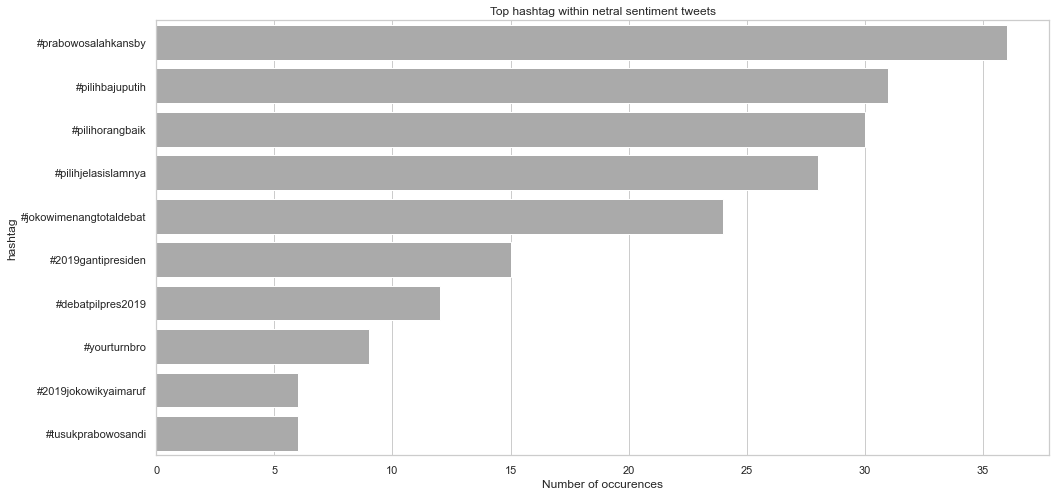

In [42]:
all_hashtags = []
_ = tweets_netral['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.4. Positive  Sentiment

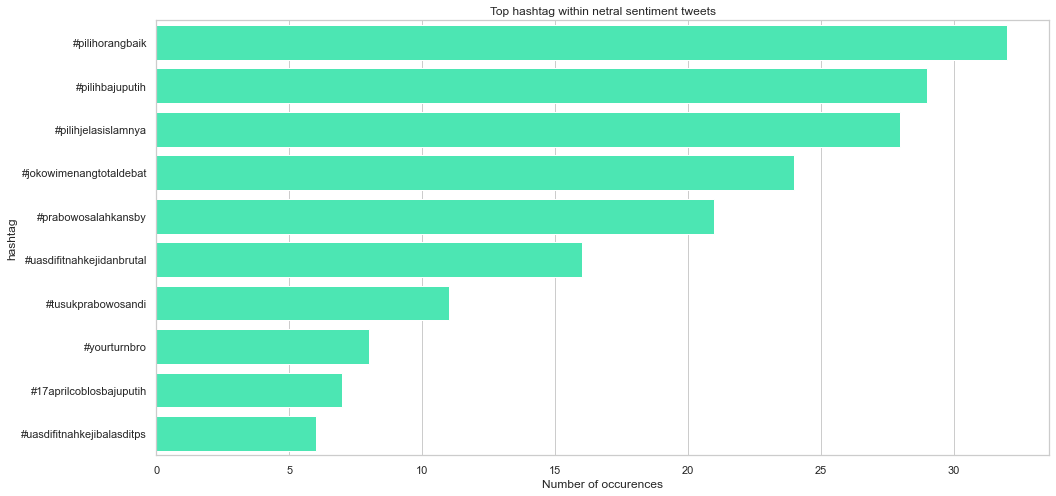

In [43]:
all_hashtags = []
_ = tweets_positif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### Data Modelling 

In [44]:
tweets.head()

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words,tokenized tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10,"[prabowo, indonesia, harga, bangsa, asing, berita, hoax, kuasa, kan, rockerung]"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9,"[batu, langka, tasbih, jokowi, haah, habib, luthfi, harga, mercy]"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7,"[era, jokowi, ekonomi, indonesia, baik, jokowilagi, jokowimenangtotaldebat]"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14,"[sumatera, selatan, asi, games, dampak, ekonomi, langsung, preksi, capai, triliun, indonesia, maju, jokowi, hebat]"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20,"[negara, ngutang, bngun, infrastruktur, pake, masyarakat, masyarakat, ngeluh, negara, ngutang, negara, ngutang, utang, bayar, negara, hasil, hasil, negara, dari, pajak]"


In [197]:
# Load libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [198]:
X = tweets['cleaned_tweet']
Y = tweets['sentimen']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

In [200]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1361,), (454,), (1361,), (454,))

In [201]:
vocabulary_size = 10000
count_vector = CountVectorizer() 
# Fit the training data
X_train_vectorized = count_vector.fit_transform(X_train)
# Transform testing data
X_test_vectorized = count_vector.transform(X_test)

In [202]:
X_train_vectorized.shape, X_test_vectorized.shape, y_train.shape, y_test.shape

((1361, 4654), (454, 4654), (1361,), (454,))

### Tokenizing & Padding

In [203]:
max_words = 10000
max_len=250

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len)
    # return sequences
    return X, tokenizer



X, tokenizer = tokenize_pad_sequences(tweets['cleaned_tweet'])

In [204]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [205]:
Y = tweets['sentimen']
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=1)

print('Train Set ->', X_train.shape, y_train.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (1452, 250) (1452, 3)
Test Set -> (363, 250) (363, 3)


### LSTM

In [210]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.utils import pad_sequences
from keras.callbacks import History
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras import losses

vocab_size = 20000
embedding_size = 250
epochs=20

# Build model
model= Sequential()
model.add(Input(shape = [max_len]))
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=False))) 
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [211]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 250, 250)          5000000   
                                                                 
 bidirectional_24 (Bidirecti  (None, 128)              161280    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 3)                 387       
                                                                 
Total params: 5,161,667
Trainable params: 5,161,667
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
23/23 [==============================] - 50s 2s/step - loss: 1.0804 - accuracy: 0.3981 - prec

In [212]:
# Evaluate model on the train set
loss, accuracy, precision, recall = model.evaluate(X_train, y_train, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9959
Precision : 0.9966
Recall    : 0.9952
F1 Score  : 0.9959


In [213]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.5923
Precision : 0.5983
Recall    : 0.5868
F1 Score  : 0.5925


In [214]:
### Evaluate model on train set
pred = model.predict(X_train).argmax(axis = 1)
true = y_train.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

46/46 [==============================] - 14s 285ms/step
              precision    recall  f1-score   support

     negatif       1.00      0.99      1.00       479
      netral       1.00      1.00      1.00       480
     positif       0.99      1.00      1.00       493

    accuracy                           1.00      1452
   macro avg       1.00      1.00      1.00      1452
weighted avg       1.00      1.00      1.00      1452



In [215]:
### Evaluate model on test set
pred = model.predict(X_test).argmax(axis = 1)
true = y_test.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

12/12 [==============================] - 3s 274ms/step
              precision    recall  f1-score   support

     negatif       0.64      0.69      0.67       117
      netral       0.60      0.51      0.55       127
     positif       0.54      0.58      0.56       119

    accuracy                           0.59       363
   macro avg       0.59      0.59      0.59       363
weighted avg       0.59      0.59      0.59       363



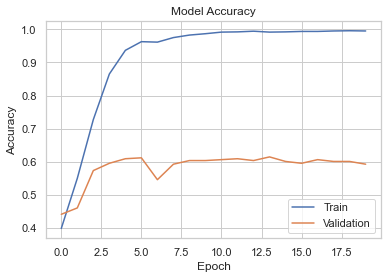

In [230]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_training_hist(history)

12/12 [==============================] - 3s 290ms/step


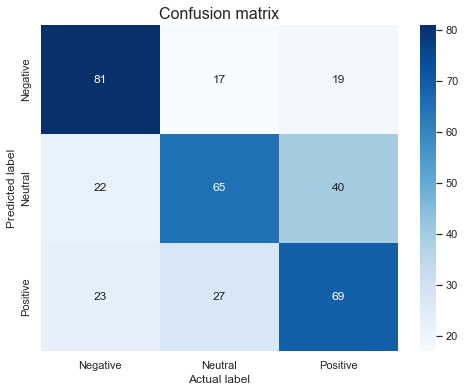

In [217]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Next Improvements
- try change model setup
- handle slang word
- make pre-processing better
- try to analyze more when Tokenizing and Padding
- setup for early stopping

In [233]:
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['negatif', 'netral', 'positif']
    max_len = 250  # Update the max_len to match the expected input length
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [234]:
predict_class(['"Jokowi 2 periode'])

1/1 [==============================] - 1s 747ms/step
The predicted sentiment is netral


In [235]:
predict_class(['"Prabowo Jelek'])

1/1 [==============================] - 0s 43ms/step
The predicted sentiment is netral


In [236]:
predict_class(['"Pemilu 2019 ricuh'])

1/1 [==============================] - 0s 40ms/step
The predicted sentiment is netral


In [237]:
predict_class(['"Pemilu aman'])

1/1 [==============================] - 0s 41ms/step
The predicted sentiment is netral
